# Propensy Score

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

To measure the effect of an intervention, the ideal would be to assign "treatment" to a group and compare it with a control group, and obtain the effect of the treatment, since the 2 groups are comparable.

However, since this does not always happen, there will be cases in which the treatment may be conditioned by other variables, such as if you want to see the effect of the academies on the performance of the students, being able to go to an academy may be conditional on income. relatives, distance or other variables, which can determine if the student decides (can) go or not to an academy to improve their academic performance.

One method to make these 2 groups "comparable" is "propensity score matching", which consists of calculating the individual's probability of treatment and transferring this probability to the estimation of the effect of the intervention.
The assumptions that support this method are the following:

- Conditional Independence Assumption: who receives the treatment is completely determined by the observable characteristic
- Common support: treatment group and control group are comparable

The first assumption is based on the fact that we have all the variables, which can explain whether a variable can be exposed to treatment. In contrast, the second assumption states that there will be close observations. That is if a person (who receives treatment) has a 90% probability of receiving treatment, he is “equal” to a person who did not receive treatment with a 90% probability (or a number close to it), In the same way, so if the probability is 10%, there must be observations in both groups.

This is how works,

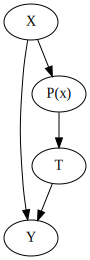

In [2]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "P(x)")
g.edge("P(x)", "T")
g

## Steps

- Calculate the propensity (probability)
- use propensity, to create a control group compared to the treatment group
- Check the similarity of groups
- Estimate the effect on the variable of interest (ATE)

To calculate the propensity, it is necessary to estimate using a binary model (logit, probit, xboost, random forest,...) the probability of being treated, taking the rest of the variables as explanatory variables (not including the variable of interest), in this case, they can create ML models, but in this method, it is not good to have exact predictions.
Visually an ML model, you want the shared part to be as small as possible to have accurate predictions.

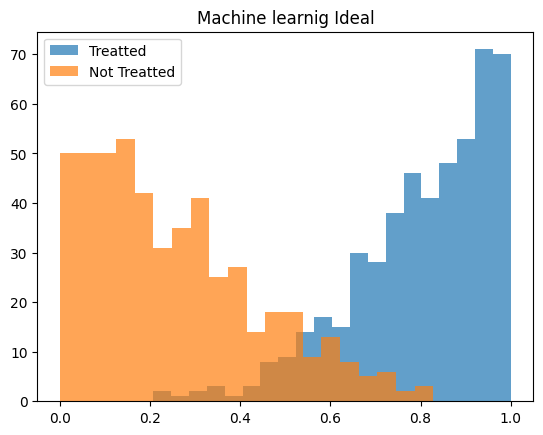

In [3]:
np.random.seed(1)
x_treat_pred = np.random.beta(4, 1, 500)
x_contl_pred = np.random.beta(1, 3, 500)
plt.hist(x_treat_pred, alpha = .7, bins=20, label = "Treatted")
plt.hist(x_contl_pred, alpha = .7, bins=20, label = "Not Treatted")
plt.title("Machine learnig Ideal")
plt.legend();

We use probabilities to create groups and see if the groups can be compared. Visually we want the groups to be distributed as follows, so that they comply with the second assumption, that there are individuals who share the same probability of both groups so that they are comparable.

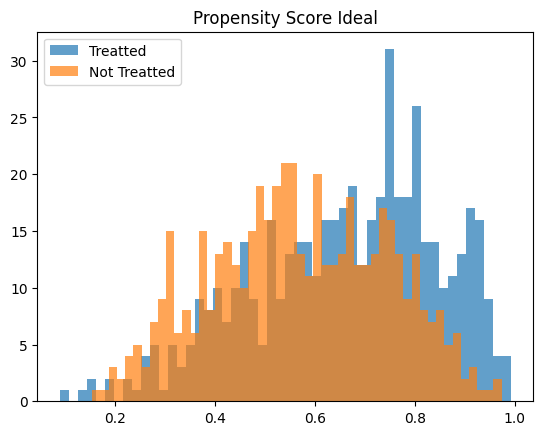

In [4]:
np.random.seed(1)
x_treat_pred = np.random.beta(4, 2, 500)
x_contl_pred = np.random.beta(4, 3, 500)
plt.hist(x_treat_pred, alpha = .7, bins=50, label = "Treatted")
plt.hist(x_contl_pred, alpha = .7, bins=50, label = "Not Treatted")
plt.title("Propensity Score Ideal")
plt.legend();

## Aplication: The Psychology of Growth


### Context 

The field of positive psychology studies what human behaviors lead to a great life. The idea is that people can have a fixed or a growth mindset. If you have a fixed mindset, you believe that abilities are given at birth or in early childhood. As such, intelligence is fixed and can't change throughout life. If you don't have it by now, you can't acquire it. The corollary of this thought is that you should not waste time on areas where you don't excel, since you will never learn how to handle them. On the other hand, if you have a growth mindset, you believe that intelligence can be developed. 

Researchers designed the The National Study of Learning Mindsets. It is a randomised study conducted in U.S. public high schools which aims at finding the impact of a growth mindset. The way it works is that students receive from the school a seminar to instil in them a growth mindset. Then, they follow up the students in their college years to measure how well they’ve performed academically.

Besides the treated and outcome variables, the study also recorded some other features:

- `schoolid`: identifier of the student’s school;
- `success_expect`: self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment;
- `ethnicity`: categorical variable for student race/ethnicity;
- `gender`: categorical variable for student identified gender;
- `frst_in_family`: categorical variable for student first-generation status, i.e. first in family to go to college;
- `school_urbanicity`: school-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc;
- `school_mindset`: school-level mean of students’ fixed mindsets, reported prior to random assignment, standardized;
- `school_achievement`: school achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students, standardized;
- `school_ethnic_minority`: school racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American, standardized;
- `school_poverty`: school poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line, standardized;
- `school_size`: total number of students in all four grade levels in the school, standardized.

In [5]:
# Data
data = pd.read_csv("https://github.com/matheusfacure/python-causality-handbook/raw/master/causal-inference-for-the-brave-and-true/data/learning_mindset.csv")
data.shape
data.head()

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
0,76,1,0.277359,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.449646,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.769703,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.121763,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,1.526147,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


We can see that the treated have an achievement score that is, on average, $0.3185 (0.4723 - 0.1538)$ higher than the average score

In [6]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


The treated are 0.3185 deviations above the untreated. 
Visually we can see this difference in the following graph between treated and untreated.

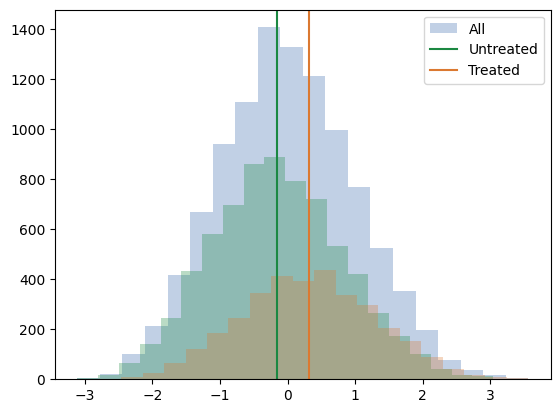

In [7]:
a_ll = "#3464A9"
t_reat = "#DB7931"
c_ontrol = "#1B8842"
a_lpha = .3

plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All", color = a_ll)
plt.hist(data[data["intervention"] == 0]["achievement_score"], bins=20, alpha=a_lpha, color=c_ontrol)
plt.hist(data[data["intervention"] == 1]["achievement_score"], bins=20, alpha=a_lpha, color=t_reat)
plt.axvline(-0.1538, label="Untreated", color=c_ontrol)
plt.axvline(-0.1538+0.4723,  label="Treated", color=t_reat)
plt.legend();


### Propensity Score Estimation

We need to replace the true propensity score by an estimation of it, we can use logistic regression (machine learning methods)

In [8]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

data_with_categ.head()

,schoolid,intervention,achievement_score,success_expect,frst_in_family,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size,...,ethnicity_13,ethnicity_14,ethnicity_15,gender_1,gender_2,school_urbanicity_0,school_urbanicity_1,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
0,76,1,0.277359,6,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,0,0,0,0,1,0,0,0,0,1
1,76,1,-0.449646,4,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,0,0,0,0,1,0,0,0,0,1
2,76,1,0.769703,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,0,0,0,0,1,0,0,0,0,1
3,76,1,-0.121763,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,0,0,0,0,1,0,0,0,0,1
4,76,1,1.526147,6,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,...,0,0,0,1,0,0,0,0,0,1


Estimate the propensity score using logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(ps=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "ps"]].head()

,intervention,achievement_score,ps
0,1,0.277359,0.315467
1,1,-0.449646,0.263620
2,1,0.769703,0.344030
3,1,-0.121763,0.344030
4,1,1.526147,0.367824


We must ensure that the weighting reconstructs the population, in which everyone is treated. Using $1 / P(x)$ creates the population where everyone receives treatment and providing the weights $1 / (1 -P(x))$ creates the population where everyone does not receive treatment.

In [10]:
weight_t = 1/data_ps[data_ps.intervention == 1]["ps"]
weight_nt = 1/(1-data_ps[data_ps.intervention == 1]["ps"])

We can see in the graph that the assumption of common support is fulfilled, this is what we call a nicely balanced treated and untreated population.

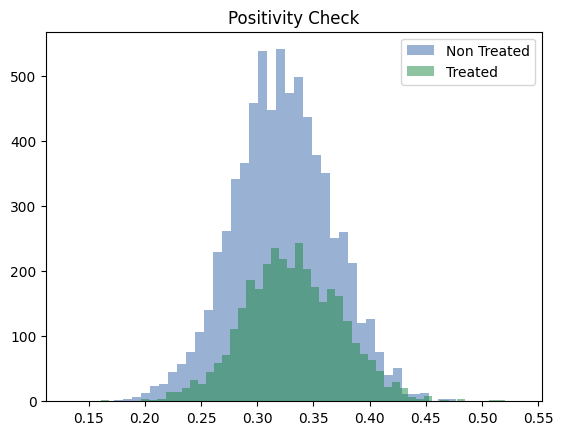

In [11]:
cl = np.unique(data_ps.intervention)
cl_lbl = ["Non Treated", "Treated"]
c_olor = [a_ll] + [c_ontrol]
for i in range(2):
    plt.hist(data_ps[data_ps.intervention == cl[i]].ps, 50, label = cl_lbl[i], alpha = .5, color = c_olor[i])
plt.title("Positivity Check")
plt.legend();
# plt.hist(data_ps.ps, 100)

Finally, we can use our propensity score weighting estimator to estimate the average treatment effect.

In [12]:
weight = ((data_ps["intervention"]-data_ps["ps"]) /
          (data_ps["ps"]*(1-data_ps["ps"])))

ate = np.mean(weight * data_ps["achievement_score"])


print("ATE", np.mean(weight * data_ps["achievement_score"]))

ATE 0.38848033425890455


Propensity score weighting is saying that we should expect treated individuals to be 0.38 standard deviations above their untreated fellows, in terms of achievements.

### Standard Error

To compute the standard error for the IPTW estimator, we can use the formula of the variance of a weighted average.

$$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$$

However, we can only use this if we have the true propensity score. If we are using the estimated version of it, 
, we need to account for the errors in this estimation process. The easiest way of doing this is by bootstrapping the whole procedure. This is achieved by sampling with replacement from the original data and computing the ATE like we did above. We then repeat this many times to get the distribution of the ATE estimate.

In [13]:
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

ates = []
# run 1000 bootstrap samples
bootstrap_sample = 1000
for i in range(bootstrap_sample):
    at = run_ps(data_with_categ.sample(frac=1, replace=True), X, T, Y)
    ates.append(at)


The ATE is then the mean of the bootstrap samples. To get confidence intervals, we can inspect the quantiles of the bootstrap distribution. For the 95% C.I., we use the 2.5 and 97.5 percentiles.

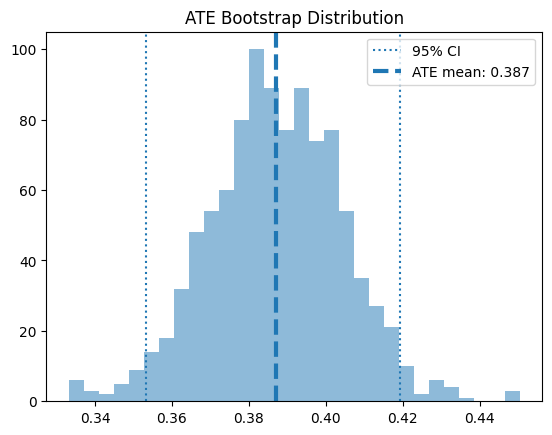

In [14]:
ate_mean = round(np.mean(ates), 3)
plt.hist(ates, bins = 30, alpha = .5)
plt.axvline(np.percentile(ates, 2.5), linestyle="dotted")
plt.axvline(np.percentile(ates, 97.5), linestyle="dotted", label="95% CI")
plt.axvline(ate_mean, linestyle="--", lw = 3, label=f"ATE mean: {ate_mean}")
plt.title("ATE Bootstrap Distribution")
plt.legend();

### Propensity Score Matching

We don’t need to control for X when you have the propensity score. It suffices to control for it. As such, you can think of the propensity score as performing a kind of dimensionality reduction on the feature space. It condenses all the features in X into a single treatment assignment dimension. For this reason, we can treat the propensity score as an input feature for other models. Take a regression, model for instance.

In [15]:
smf.ols("achievement_score ~ intervention + ps", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0760,0.065,-47.064,0.000,-3.204,-2.948
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
ps,9.0523,0.200,45.316,0.000,8.661,9.444


If we control for the propensity score, we now estimate a ATE of 0.39, which is lower than the 0.47 we got previously with a regression model without controlling for the propensity score. We can also use matching on the propensity score. This time, instead of trying to find matches that are similar in all the X features, we can find matches that just have the same propensity score.

To measure the ATE, we can use the [`causalinference`](https://causalinferenceinpython.org/index.html) package which we only have to place the parameters to obtain the results

In [16]:
from causalinference import CausalModel

In [17]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["ps"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.380      0.025     15.067      0.000      0.331      0.430
           ATC      0.373      0.028     13.415      0.000      0.318      0.427
           ATT      0.396      0.027     14.734      0.000      0.344      0.449



As we can see, we also get an ATE of 0.38, which is more in line with what we’ve seen before with propensity score weighting. Matching on the propensity score also gives us some intuition about why it is dangerous to have a small overlap in the propensity score between treated and untreated. If this happens, the matching on the propensity score discrepancy will be large, which will lead to bias.